In [1]:
import matplotlib.pyplot as plt

from scipy import signal
import numpy as np
import scipy as sp
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import math

data_length = 400

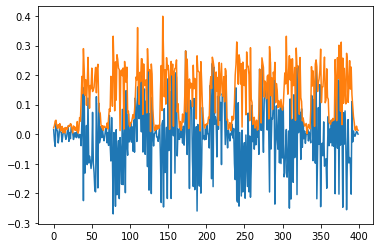

In [2]:
data0 = np.load("try_0_1_short.npy")[:data_length]
plt.figure().set_facecolor('white')
plt.plot(data0.real)
plt.plot(np.abs(data0))
plt.show()

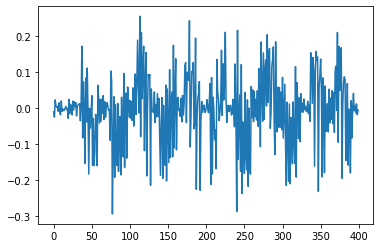

In [3]:
data7 = np.load("try_7_1_short.npy")[:data_length]
plt.figure()
plt.plot(data7.real)
plt.show()

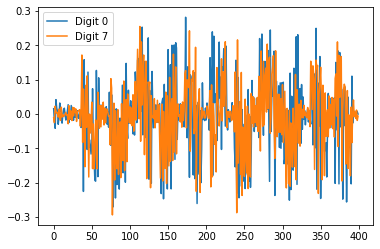

In [4]:
plt.figure()
plt.plot(data0.real, label="Digit 0")
plt.plot(data7.real, label="Digit 7")
plt.legend()
plt.show()

In [5]:

bandpass_start = 0.55
bandpass_end = 0.60
bandpass_order = 4

def apply_bandpass(s, order=bandpass_order, low=bandpass_start, high=bandpass_end):

    b, a = signal.butter(order, [low, high], btype='band')
    zi = signal.lfilter_zi(b, a)
    z, _ = signal.lfilter(b, a, s, zi=zi*s[0])
    return z


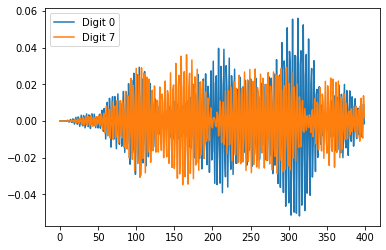

In [6]:

plt.figure()
plt.plot(apply_bandpass(data0).real, label="Digit 0")
plt.plot(apply_bandpass(data7).real, label="Digit 7")
plt.legend()
plt.show()

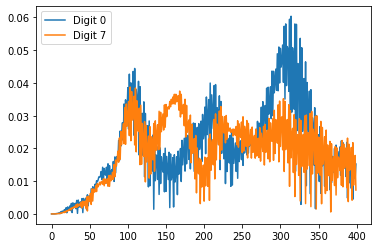

In [7]:
plt.figure()
plt.plot(np.abs(apply_bandpass(data0)), label="Digit 0")
plt.plot()
plt.plot(np.abs(apply_bandpass(data7)).real, label="Digit 7")
plt.legend()
plt.show()

In [8]:

scaler = MinMaxScaler()


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


In [9]:
def load_data():
    digits = [0, 7, 8, 9]
    training_data = []
    training_labels = []
    for digit in digits:
        for i in range(1, 41):
            filename = "try_%d_%d_short.npy" % (digit, i)
            try:
              data = np.abs(apply_bandpass(np.load(filename)[:data_length])).real
            except:
              continue
            data = scaler.fit_transform(np.reshape(data, (20, 20)))
            training_data.append(data)
            training_labels.append(digit)
    training_data = np.array(training_data)
    training_labels = np.array(training_labels)
    training_data, training_labels = unison_shuffled_copies(training_data, training_labels)
    
    test_data = []
    test_labels = []
    for digit in digits:
        for i in range(41, 51):
            filename = "try_%d_%d_short.npy" % (digit, i)
            try:
              data = np.abs(apply_bandpass(np.load(filename)[:data_length])).real
            except:
              continue
            data = scaler.fit_transform(np.reshape(data, (20, 20)))
            test_data.append(data)
            test_labels.append(digit)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    test_data, test_labels = unison_shuffled_copies(test_data, test_labels)
    
    
    
    return (training_data, training_labels), (test_data, test_labels)
  

(train_data, train_labels), (test_data, test_labels) = load_data()

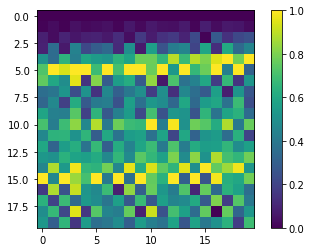

In [10]:
plt.figure()
plt.imshow(train_data[1])
plt.colorbar()
plt.grid(False)

In [11]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(20, 20)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.save_weights("pre-fit.weights")

In [13]:
history = model.fit(train_data, train_labels, epochs=200, verbose=0, validation_split=0.2)

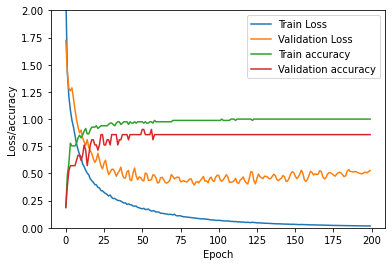

In [14]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss/accuracy')
  plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Validation Loss')
  plt.plot(history.epoch, np.array(history.history['acc']),
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Validation accuracy')
  plt.legend()
  plt.ylim([0, 2])

plot_history(history)



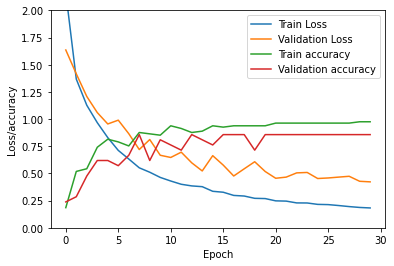

In [15]:

model.load_weights("pre-fit.weights")
history = model.fit(train_data, train_labels, epochs=30, verbose=0, validation_split=0.2)
plot_history(history)

In [16]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Accuracy on testdata:', test_acc * 100, "%")

26/26 [==============================] - 0s 73us/sample - loss: 0.1748 - acc: 0.9615
Accuracy on testdata: 96.15384340286255 %


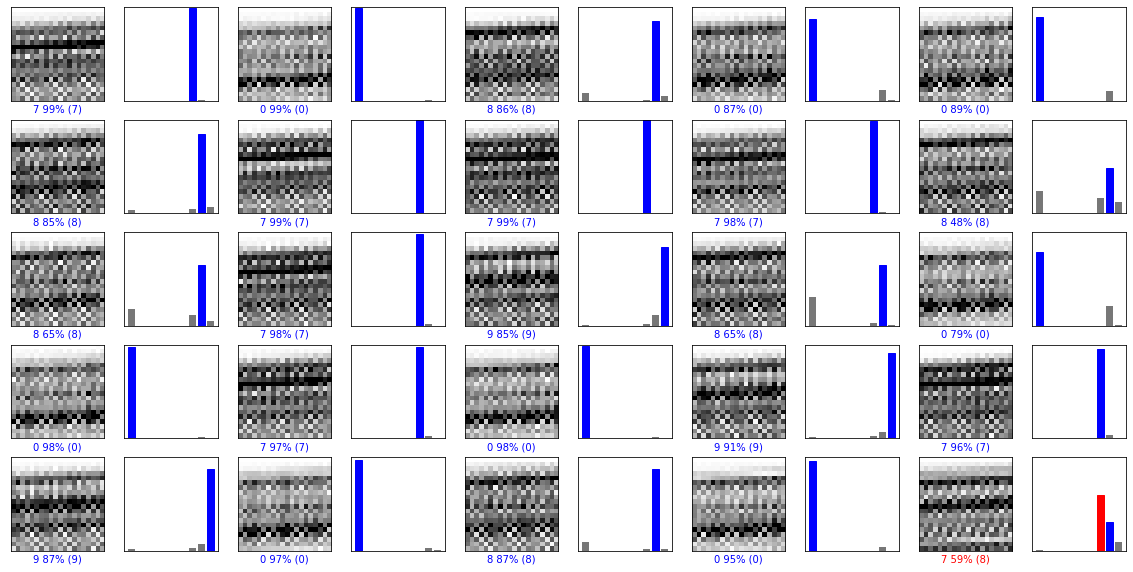

In [17]:
predictions = model.predict(test_data)

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(str(predicted_label),
                                100*np.max(predictions_array),
                                str(true_label)),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_data)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
